In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Unfortunately, there is no general rule how to find the sweet spot, and so machine learning practitioners have to find the best trade-off of model-complexity and generalization by trying several hyperparameter settings. Hyperparameters are the internal knobs or tuning parameters of a machine learning algorithm (in contrast to model parameters that the algorithm learns from the training data -- for example, the weight coefficients of a linear regression model); the number of k in K-nearest neighbors is such a hyperparameter.

Most commonly this "hyperparameter tuning" is done using a brute force search, for example over multiple values of n_neighbors:

In [2]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
# generate toy dataset:
x = np.linspace(-3, 3, 100)
rng = np.random.RandomState(42)
y = np.sin(4 * x) + x + rng.normal(size=len(x))
X = x[:, np.newaxis]

cv = KFold(shuffle=True)

# for each parameter setting do cross-validation:
for n_neighbors in [1, 3, 5, 10, 20]:
    scores = cross_val_score(KNeighborsRegressor(n_neighbors=n_neighbors), X, y, cv=cv)
    print("n_neighbors: %d, average score: %f" % (n_neighbors, np.mean(scores)))

n_neighbors: 1, average score: 0.419797
n_neighbors: 3, average score: 0.706051
n_neighbors: 5, average score: 0.705495
n_neighbors: 10, average score: 0.722024
n_neighbors: 20, average score: 0.642875


There is a function in scikit-learn, called validation_plot to reproduce the cartoon figure above. It plots one parameter, such as the number of neighbors, against training and validation error (using cross-validation):

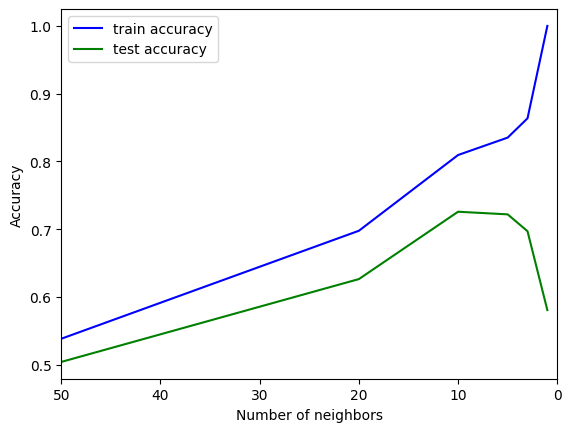

In [3]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 3, 5, 10, 20, 50]
train_scores, test_scores = validation_curve(KNeighborsRegressor(), X, y, param_name="n_neighbors",
                                             param_range=n_neighbors, cv=cv)
plt.plot(n_neighbors, train_scores.mean(axis=1), 'b', label="train accuracy")
plt.plot(n_neighbors, test_scores.mean(axis=1), 'g', label="test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbors')
plt.xlim([50, 0])
plt.legend(loc="best");

If multiple parameters are important, like the parameters C and gamma in an SVM, all possible combinations are tried:

In [4]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR

# each parameter setting do cross-validation:
for C in [0.001, 0.01, 0.1, 1, 10]:
    for gamma in [0.001, 0.01, 0.1, 1]:
        scores = cross_val_score(SVR(C=C, gamma=gamma), X, y, cv=cv)
        print("C: %f, gamma: %f, average score: %f" % (C, gamma, np.mean(scores)))

C: 0.001000, gamma: 0.001000, average score: -0.064423
C: 0.001000, gamma: 0.010000, average score: -0.285017
C: 0.001000, gamma: 0.100000, average score: -0.003339
C: 0.001000, gamma: 1.000000, average score: -0.068855
C: 0.010000, gamma: 0.001000, average score: -0.184468
C: 0.010000, gamma: 0.010000, average score: -0.061224
C: 0.010000, gamma: 0.100000, average score: 0.076521
C: 0.010000, gamma: 1.000000, average score: 0.057790
C: 0.100000, gamma: 0.001000, average score: -0.040935
C: 0.100000, gamma: 0.010000, average score: 0.176103
C: 0.100000, gamma: 0.100000, average score: 0.518835
C: 0.100000, gamma: 1.000000, average score: 0.515106
C: 1.000000, gamma: 0.001000, average score: 0.185803
C: 1.000000, gamma: 0.010000, average score: 0.592634
C: 1.000000, gamma: 0.100000, average score: 0.634335
C: 1.000000, gamma: 1.000000, average score: 0.702030
C: 10.000000, gamma: 0.001000, average score: 0.546508
C: 10.000000, gamma: 0.010000, average score: 0.619053
C: 10.000000, gamma

As this is such a very common pattern, there is a built-in class for this in scikit-learn, GridSearchCV. GridSearchCV takes a dictionary that describes the parameters that should be tried and a model to train.

The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

In [5]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv)

One of the great things about GridSearchCV is that it is a meta-estimator. It takes an estimator like SVR above, and creates a new estimator, that behaves exactly the same - in this case, like a regressor. So we can call fit on it, to train it:

In [6]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1]})

What fit does is a bit more involved then what we did above. First, it runs the same loop with cross-validation, to find the best parameter combination. Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation), to built a single new model using the best parameter setting.

Then, as with all models, we can use predict or score:

In [7]:
grid.predict(X)

array([-1.79762875, -1.74054091, -1.71412904, -1.72272347, -1.76880247,
       -1.8527208 , -1.97255382, -2.12407501, -2.30087676, -2.49463429,
       -2.695503  , -2.89262935, -3.07474705, -3.23082299, -3.35071314,
       -3.42578612, -3.44947391, -3.41771237, -3.32924127, -3.18574205,
       -2.9918017 , -2.75470244, -2.48404785, -2.19124658, -1.88888388,
       -1.59001819, -1.30744475, -1.05297034, -0.8367425 , -0.66667333,
       -0.54799235, -0.4829551 , -0.4707249 , -0.50743515, -0.58642852,
       -0.69865919, -0.83323456, -0.97806438, -1.12057877, -1.24847261,
       -1.35043139, -1.41679516, -1.44012026, -1.41560488, -1.3413525 ,
       -1.21845724, -1.05090633, -0.84530623, -0.61045003, -0.35675398,
       -0.09559933,  0.16137852,  0.40300817,  0.61926205,  0.80185531,
        0.94472644,  1.04437082,  1.10000798,  1.11357463,  1.08954695,
        1.03460678,  0.95717608,  0.86685224,  0.7737823 ,  0.68801751,
        0.61888941,  0.57444669,  0.56098656,  0.58270777,  0.64

You can inspect the best parameters found by GridSearchCV in the best_params_ attribute, and the best score in the best_score_ attribute:

In [8]:
print(grid.best_score_)

0.7320867200235476


In [9]:
print(grid.best_params_)

{'C': 10, 'gamma': 1}


But you can investigate the performance and much more for each set of parameter values by accessing the cv_results_ attributes. The cv_results_ attribute is a dictionary where each key is a string and each value is array. It can therefore be used to make a pandas DataFrame.

In [10]:
type(grid.cv_results_)

dict

In [11]:
print(grid.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [12]:
import pandas as pd

cv_results = pd.DataFrame(grid.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001000,0.000003,0.002003,0.001084,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",-0.023487,-0.002420,0.000272,-0.156741,-0.055093,-0.047494,0.058107,20
1,0.001196,0.000402,0.000999,0.000007,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",-0.020848,0.000013,0.002636,-0.153705,-0.052340,-0.044849,0.057878,19
2,0.001000,0.000007,0.000802,0.000401,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",-0.008881,0.010552,0.013441,-0.140644,-0.039784,-0.033063,0.057041,16
3,0.000805,0.000402,0.000601,0.000491,0.001,1,"{'C': 0.001, 'gamma': 1}",-0.010707,0.008711,0.012314,-0.143371,-0.040704,-0.034751,0.057473,17
4,0.000800,0.000400,0.000812,0.000406,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",-0.020592,0.000265,0.002863,-0.153389,-0.052075,-0.044586,0.057850,18


In [13]:
cv_results_tiny = cv_results[['param_C', 'param_gamma', 'mean_test_score']]
cv_results_tiny.sort_values(by='mean_test_score', ascending=False).head()

,param_C,param_gamma,mean_test_score
19,10,1,0.732087
15,1,1,0.700491
14,1,0.1,0.655548
18,10,0.1,0.650800
17,10,0.01,0.614528


We can do this very easily by splitting of some test data using train_test_split, training GridSearchCV on the training set, and applying the score method to the test set:

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
cv = KFold(n_splits=10, shuffle=True)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.7262035177984737

We can also look at the parameters that were selected:

In [15]:
grid.best_params_

{'C': 10, 'gamma': 1}

Some practitioners go for an easier scheme, splitting the data simply into three parts, training, validation and testing. This is a possible alternative if your training set is very large, or it is infeasible to train many models using cross-validation because training a model takes very long. You can do this with scikit-learn for example by splitting of a test-set and then applying GridSearchCV with ShuffleSplit cross-validation with a single iteration:

In [16]:
from sklearn.model_selection import train_test_split, ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
single_split_cv = ShuffleSplit(n_splits=1)

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=single_split_cv, verbose=3)

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV 1/1] END .............C=0.001, gamma=0.001;, score=-0.101 total time=   0.0s
[CV 1/1] END ..............C=0.001, gamma=0.01;, score=-0.099 total time=   0.0s
[CV 1/1] END ...............C=0.001, gamma=0.1;, score=-0.086 total time=   0.0s
[CV 1/1] END .................C=0.001, gamma=1;, score=-0.087 total time=   0.0s
[CV 1/1] END ..............C=0.01, gamma=0.001;, score=-0.098 total time=   0.0s
[CV 1/1] END ...............C=0.01, gamma=0.01;, score=-0.074 total time=   0.0s
[CV 1/1] END .................C=0.01, gamma=0.1;, score=0.028 total time=   0.0s
[CV 1/1] END ...................C=0.01, gamma=1;, score=0.025 total time=   0.0s
[CV 1/1] END ...............C=0.1, gamma=0.001;, score=-0.072 total time=   0.0s
[CV 1/1] END .................C=0.1, gamma=0.01;, score=0.140 total time=   0.0s
[CV 1/1] END ..................C=0.1, gamma=0.1;, score=0.512 total time=   0.0s
[CV 1/1] END ....................C=0.1, gamma=1;

0.7262035177984737

This is much faster, but might result in worse hyperparameters and therefore worse results.

In [17]:
clf = GridSearchCV(SVR(), param_grid=param_grid)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7262035177984737